In [66]:
import numpy as np
from numpy import sin,arcsin, cos,pi
from scipy.linalg import *
from scipy.optimize import fsolve,root
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from matplotlib import animation
from IPython.display import HTML

from IPython.display import YouTubeVideo
YouTubeVideo('-A1w46iqUlE')

def rotA(theta):
    '''This function returns a 2x2 rotation matrix to convert the 
    rotated coordinate to the global coordinate system
    input is angle in radians
        
    Parameters
    ----------
    theta : angle in radians
    
    Returns
    -------
    A : 2x2 array to rotate a coordinate system at angle theta to global x-y
    '''
    A=np.zeros((2,2))
    A=np.array([[np.cos(theta), -np.sin(theta)],
               [np.sin(theta), np.cos(theta)]])
    return A


In [125]:
#Problem 3 - In this Problem we change the constraints of the slider crank but we utilize the same function to determine the generalized coordinated q
L1 = 0.15
L2 = 0.25
w = 150
x0= 0.2;
t = 0;

def links(l1 = L1, l2 = L2):
    return l1,l2

def q_slidercrank(t,w,x0): #Used to determine initial states
    L1,L2 = links()
    q = np.zeros(9)
    
    #Determine the location of the sliding block
    q[6] = x0-0.8*(L2)**2*sin(w*t)
    q[7]  = 0;
    
    #Numerically Solve for a possible theta 1 and theta 2 values with theta 1 close to pi/4
    f = lambda theta1: L1*cos(theta1)+L2*cos(-arcsin((L1/L2)*sin(theta1)))-q[6]
    theta1 = fsolve(f, pi/4)
    theta2 = -arcsin((L1/L2)*sin(theta1))
    theta1 = theta1.item()
    theta2 = theta2.item()    
    
    q[2]  = theta1
    q[5]  = theta2
    
    #Solve for the remaining generalized coordiantes
    q[0:2] = -rotA(theta1)@np.array([-L1/2,0])
    q[2] = theta1
    q[3:5]= q[0:2]+rotA(theta1)@np.array([L1/2,0])-rotA(theta2)@np.array([-L2/2,0])
    q[5]  = theta2
    q[6:8]= q[3:5]+rotA(theta2)@np.array([L2/2,0])
    q[8]  = np.arctan(q[7]/q[6]); #Should always equal zero
    return q

def C_slidercrank(q,t,w,x0):
    l1,l2=links()
    q1 = q[0:3]
    q2 = q[3:6]
    q3 = q[6:9]

    C=np.zeros(9)
    C[0:2] = q1[0:2]+rotA(q1[2])@np.array([-l1/2, 0])
    C[2:4] = q1[0:2]-q2[0:2]+rotA(q1[2])@np.array([l1/2, 0])-rotA(q2[2])@np.array([-l2/2, 0])
    C[4:6] = q2[0:2]-q3[0:2]+rotA(q2[2])@np.array([l2/2, 0])-rotA(q3[2])@np.array([0, 0])
    C[6] = q3[1]
    C[7] = q3[2]
    C[8] = q3[0] - x0 + 0.8*(L2)**2*sin(w*t)
    return C

In [126]:
#Problem 1 - Test to see if the constraint vector is zero at t=0
q = q_slidercrank(t,w,x0)
C_slidercrank(q,t,w,x0)

array([ 0.00000000e+00,  0.00000000e+00, -1.38777878e-17,  0.00000000e+00,
        1.38777878e-17,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

In [127]:
#Solution Set up - Numerical Solver

def A_theta(theta):
    '''This function returns a 2x2 rotation matrix derivative 
    input is angle in radians
        
    Parameters
    ----------
    theta : angle in radians
    
    Returns
    -------
    dAda : 2x2 array derivative of `rotA`
    '''
    dAda=np.array([[-np.sin(theta), -np.cos(theta)],
                   [np.cos(theta), -np.sin(theta)]])
    return dAda

def Cq_pin(qi, qj, ui, uj):
    '''Jacobian of a pinned constraint for planar motion

    Parameters
    ----------
    qi : generalized coordinates of the first body, i [Rxi, Ryi, thetai]
    qj : generalized coordinates of the 2nd body, i [Rxj, Ryj, thetaj]
    ui : position of the pin the body-i coordinate system
    uj : position of the pin the body-j coordinate system
        
    Returns
    -------
    Cq_pin : 2 rows x 6 columns Jacobian of pin constraint Cpin
    '''
    
    Cq_1=np.block([np.eye(2), A_theta(qi[2])@ui[:,np.newaxis] ])
    Cq_2=np.block([-np.eye(2), -A_theta(qj[2])@uj[:,np.newaxis] ])
    Cq_pin=np.block([Cq_1, Cq_2])
    return Cq_pin

def Cq_slidercrank(q,t):
    '''return Jacobian of C_slidercrank(q,t) = dC/dq_i
       |dC1/dR1x dC1/dR1y ... dC9/da3 |
       |dC2/dR1x dC2/dR1y ... dC9/da3 |
       |... ..     .           ...    |
       |            .                 |
       |             .                |
       |dC9/dR1x ...         dC9/da3  |
    Parameters
    ----------
    q : numpy array for 9 generalized coordinates for bodies 1-3 in the slider crank
        q = [q1, q2, q3]
    t : current time
    Returns
    -------
    Cq : 9 rows x 9 columns Jacobian of constraints `C_slidercrank`   
    '''
    l1, l2 = links()
    q1 = q[0:3]
    q2 = q[3:6]
    q3 = q[6:9]
    
    Cq=np.zeros((9,9))
    Cq[0:2, 0:3] = Cq_pin(q1, np.array([0, 0, 0]),np.array([-l1/2, 0]),np.array([0, 0]))[0:2, 0:3]
    Cq[2:4, 0:6] = Cq_pin(q1, q2, np.array([l1/2, 0]), np.array([-l2/2, 0]))
    Cq[4:6, 3:10] = Cq_pin(q2, q3, np.array([l2/2, 0]), np.array([0, 0]))
    Cq[6:8, 7:10] = np.eye(2)
    Cq[8, 6]=1
    return Cq

In [128]:
#Problem 2 Define Constraint Derivatives

def Qd_slidercrank(q, dq, t):
    '''return slidercrank Qd = Cq@ddq

    Parameters
    ----------
    q : numpy array for 9 generalized coordinates for bodies 1-3 in the slider crank
        q = [q1, q2, q3]
    t : current time
    Returns
    -------
    Qd : 1D array with length 9     
    '''
    l1, l2 = links()
    q1 = q[0:3]
    q2 = q[3:6]
    q3 = q[6:9]
    dq1 = dq[0:3]
    dq2 = dq[3:6]
    dq3 = dq[6:9]
    
    Qd=np.zeros(9)
    Qd[0:2] = dq1[2]**2*rotA(q1[2])@np.array([-l1/2, 0])
    Qd[2:4] = dq1[2]**2*rotA(q1[2])@np.array([l1/2, 0]) -\
              dq2[2]**2*rotA(q2[2])@np.array([-l2/2, 0])
    Qd[4:6] = dq2[2]**2*rotA(q2[2])@np.array([l2/2, 0])
    Qd[6:9] = 0
    return Qd 

def Ct_slidercrank(q, t,w,x0):
    '''return slidercrank partial derivative of constraints dC/dt

    Parameters
    ----------
    q : numpy array for 9 generalized coordinates for bodies 1-3 in the slider crank
        q = [q1, q2, q3]
    t : current time
    Returns
    -------
    Ct : 1D array with length 9
    '''
    L1, L2 = links()
    Ct = np.zeros(9)
    Ct[8] = w*0.8*(L2)**2*cos(w*t)
    return Ct

Text(0, 0.5, 'Angular Displacement (rad) - Theta1')

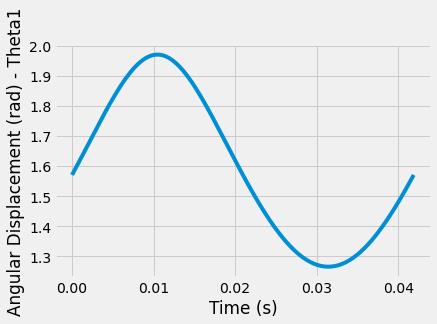

In [129]:
#Problem 3 - Plot Generalized Coordinates, Velocity, & Acceleration

#Specify System Parameters
t = np.linspace(0, 2*pi/w,200)

#Determine the initial generalized coordinated
q0 = q0 = q_slidercrank(0,w,x0)

#Allocate Array in Computer Memory
q = np.zeros((len(q0), len(t)))
dq = np.zeros(q.shape)
ddq = np.zeros(q.shape)

#Numerical Solver
q[:, 0] = q0
for i, ti in enumerate(t):
    q[:, i] = fsolve(lambda q: C_slidercrank(q, ti,w,x0),q0,\
                    fprime= lambda q: Cq_slidercrank(q, ti)) # <-- use the Jacobian to speed up solution
    dq[:, i] = np.linalg.solve(Cq_slidercrank(q[:,i], ti), -Ct_slidercrank(q[:, i], ti,w,x0))
    Qd = Qd_slidercrank(q[:, i], dq[:, i], ti)
    ddq[:, i] = np.linalg.solve(Cq_slidercrank(q[:,i], ti), Qd)
    q0=q[:, i]
    
plt.plot(t,q[2,:]) #Theta 2 Velocity vs crank angle
plt.xlabel('Time (s)')
plt.ylabel('Angular Displacement (rad) - Theta1')

Text(0, 0.5, 'Angular Displacement (rad) - Theta2')

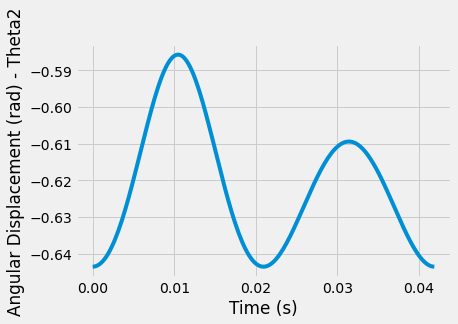

In [130]:
plt.plot(t,q[5,:]) 
plt.xlabel('Time (s)')
plt.ylabel('Angular Displacement (rad) - Theta2')

Text(0, 0.5, 'Angular Velocity (rad/s) - Theta1')

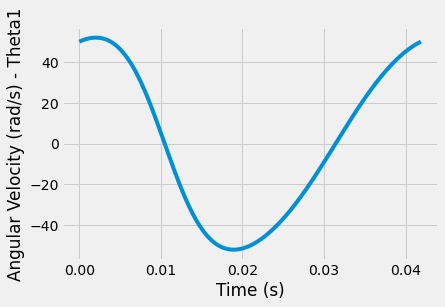

In [131]:
plt.plot(t,dq[2,:]) 
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s) - Theta1')

Text(0, 0.5, 'Angular Velocity (rad/s) - Theta2')

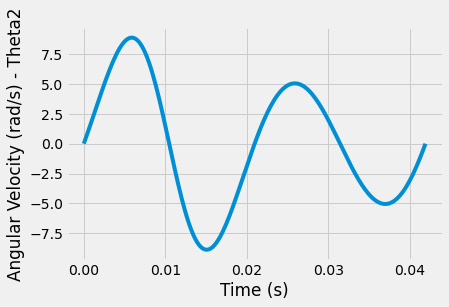

In [132]:
plt.plot(t,dq[5,:]) 
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s) - Theta2')

Text(0, 0.5, 'Angular Acceleration (rad/s^2) - Theta1')

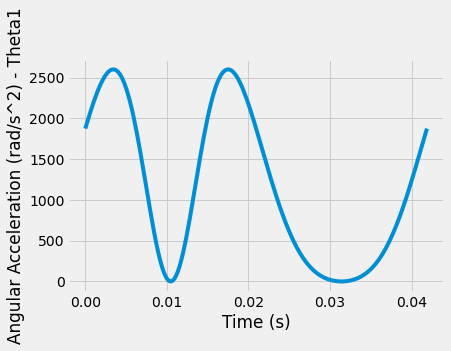

In [133]:
plt.plot(t,ddq[2,:]) 
plt.xlabel('Time (s)')
plt.ylabel('Angular Acceleration (rad/s^2) - Theta1')

Text(0, 0.5, 'Angular Acceleration (rad/s^2) - Theta2')

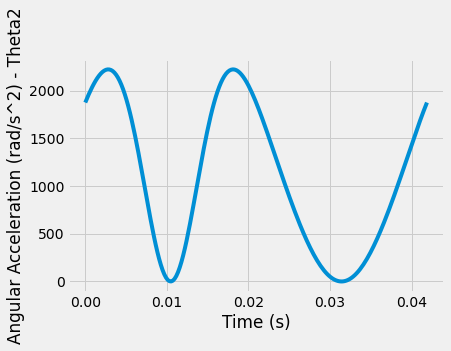

In [134]:
plt.plot(t,ddq[5,:]) 
plt.xlabel('Time (s)')
plt.ylabel('Angular Acceleration (rad/s^2) - Theta2')